# Study the neural state space
The aim of this script is to better understand the neuronal activity by regrouping the neurons into modes using PCA.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
import os
import scipy.io
import numpy.ma as ma
import scipy.signal as ss

from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.signal import find_peaks

## Importing the data 

In [2]:
rootdir = 'worms/'
data_paths=[]

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.mat'):
            data_paths.append(os.path.join(subdir, file))

fullD_tseries_w=[]
frameRate_w=[]
time_w=[]
neuronID_w=[]
wormID_w=[]
#Accessing the data for the different worms
for data_path in data_paths:
    mat=scipy.io.loadmat(data_path)
    fullD_tseries=np.array(mat['wbData']['deltaFOverF_bc'])[0][0]
    time=np.hstack(np.array(mat['wbData']['tv'])[0][0])
    neuron_IDs=np.array(mat['wbData']['NeuronIds'])[0][0]
    wormID=np.array(mat['wbData']['FlNm'])[0][0][0]
    #Identifier of observed worm
    wormID_w.append(wormID)
    #Identifier for the neuron
    neuronID_w.append(neuron_IDs)
    #Measured calcum imaging data
    fullD_tseries_w.append(fullD_tseries)
    #Rate of the imaging
    frameRate_w.append(1/(time[1]-time[0]))
    #Time of image
    time_w.append(time)

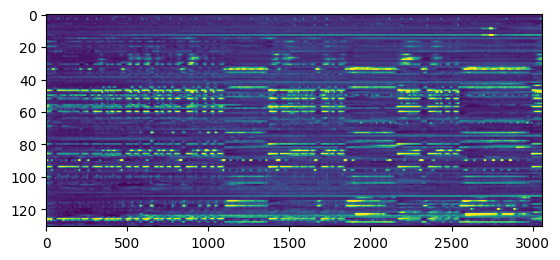

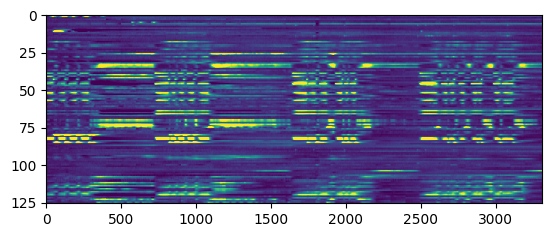

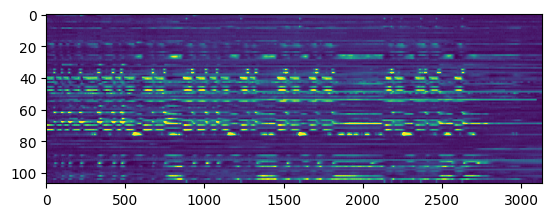

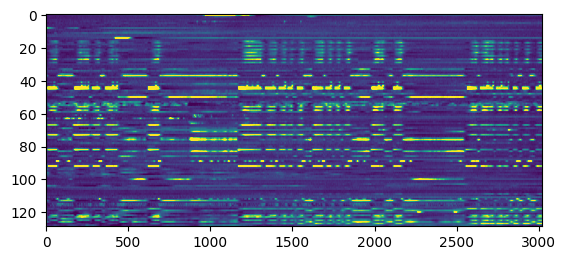

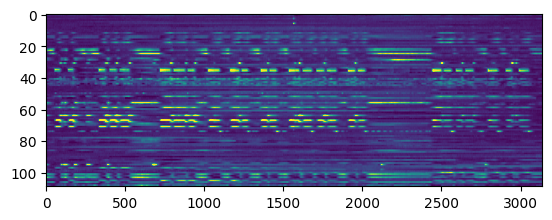

In [3]:
for kw,wormID in enumerate(wormID_w):
    plt.imshow(fullD_tseries_w[kw].T,aspect=10,vmax=1,vmin=0)
    plt.show()

### Find neurons that are common across recordings

In [4]:
#Identifies how often each neuron is active in all of the worms
indices_nID_w = []
for kw in range(len(neuronID_w)):
    indices_nID=[]
    for kn,nID in enumerate(neuronID_w[kw][0]):
        if nID.shape[1]==1:
            if nID[0][0][0][:1] != '-':
                indices_nID.append([kn,nID[0][0][0]])
    indices_nID_w.append(np.vstack(indices_nID))
    
sel_w = []
for kw in range(len(neuronID_w)):
    sel_w.append([nID in indices_nID_w[kw][:,1] for nID in indices_nID_w[2][:,1]])

sel_all = np.logical_and(sel_w[4],np.logical_and(sel_w[3],np.logical_and(sel_w[2],np.logical_and(sel_w[0],sel_w[1]))))
nIDs_all_worms = indices_nID_w[2][sel_all,1]
#Selected neurons
nIDs_all_worms

array(['RMED', 'RMER', 'RMEL', 'RID', 'ALA', 'AVAR', 'AVAL', 'AVER',
       'AIBR', 'AVBL', 'AIBL', 'RIMR', 'RIML', 'VB02', 'VB01'],
      dtype='<U21')

In [5]:
#get time series for commonly recorded neurons
tseries_w=[]
for kw in range(len(sel_w)):
    indices = []
    for nID in nIDs_all_worms:
        idxnID = indices_nID_w[kw][np.where(indices_nID_w[kw][:,1] == nID)[0]][0]
        idx = int(idxnID[0])
        indices.append(idx)
    tseries_w.append(fullD_tseries_w[kw][:,indices])

### Illustrations

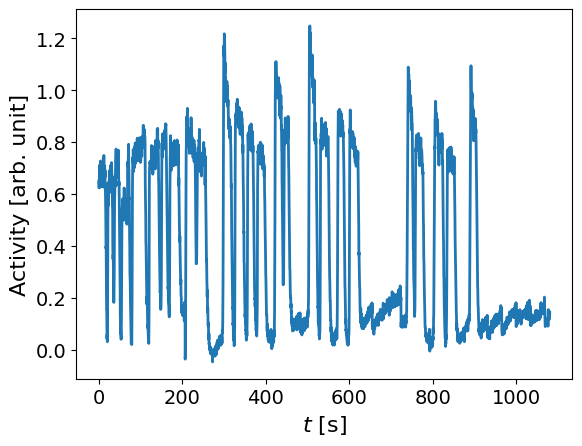

In [5]:
#Activity of AVAR over time for worm 2
fig, ax = plt.subplots()
plt.plot(time_w[2],tseries_w[2][:,5],linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.xlabel(r'$t$ [s]',fontsize=16)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
#plt.legend(fontsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('AVAR_activity_worm_2.png', format='png', dpi=600,bbox_inches='tight')
plt.show()


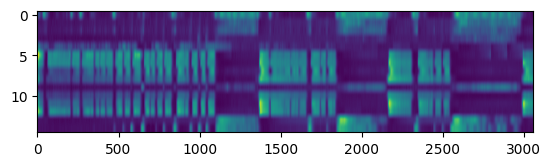

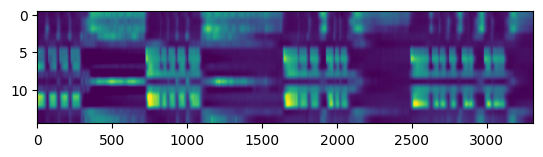

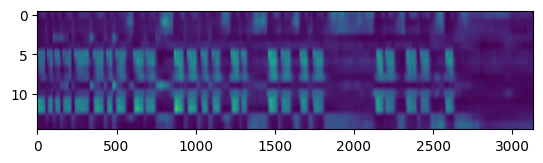

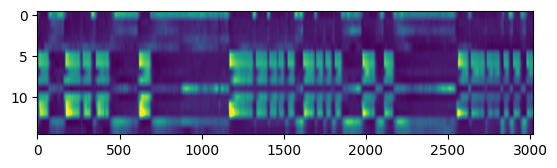

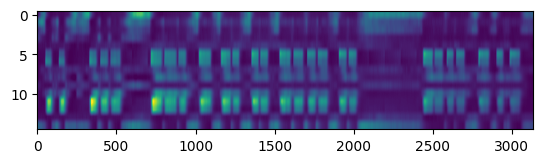

In [6]:
#Activity of the selected neurons only
for kw,wormID in enumerate(wormID_w):
    plt.imshow(tseries_w[kw].T,aspect=50,vmax=2.,vmin=0)
    plt.show()

### Interpolate to have a common sampling rate across worms
This is necessary in order to be able to have the different time series data "sampled" at the same points in time.

In [6]:
new_frameRate = 2
new_dt = 1/new_frameRate
window_length=5
poly_order=1
interp_tseries_w = []
new_times_w=[]
interp_times_w = []
for kw in range(len(sel_w)):
    x = time_w[kw]
    y = tseries_w[kw]
    f = interpolate.interp1d(x, y,kind='cubic',axis=0)
    xnew = np.arange(0, time_w[kw][-1], new_dt)
    ynew = f(xnew) 
    #added a smoothing step to get rid of some noise
    ynewf = ss.savgol_filter(ynew,window_length,poly_order,axis=0)
    interp_tseries_w.append(ynewf)
    interp_times_w.append(xnew)
    new_times_w.append(xnew)

## Do PCA to get the different modes

In [7]:
Xw = []
#Puting all the different worms data in the same time series
for kw in range(len(sel_w)):
    ts = interp_tseries_w[kw]
    ts = (ts-ts.mean())/ts.std()
    ts[:1] = ma.masked
    Xw.append(ts)
X_all = ma.vstack(Xw)
#Mask zero values (= no calcium data observed)
X_all[X_all==0] = ma.masked

X =X_all-X_all.mean(axis=0)
cov = ma.cov(X.T)
eigvals,eigvecs = np.linalg.eig(cov)

#Cummulative sum of eigenvalues (i.e. how much variance captuared by the n first eigenvalues)
print(np.cumsum(eigvals)/np.sum(eigvals))


[0.74005811 0.80188791 0.83719109 0.86768499 0.89469024 0.91775273
 0.93785134 0.95476048 0.96563619 0.97509963 0.98386037 0.9888885
 0.99206348 0.99613675 1.        ]


#### The different modes "regroup" neurons into "logical" units

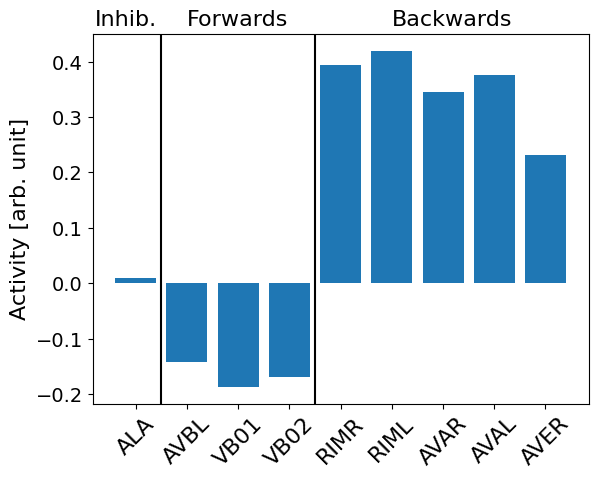

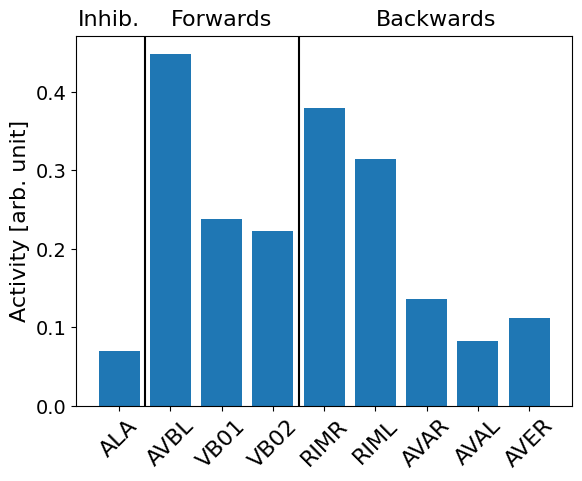

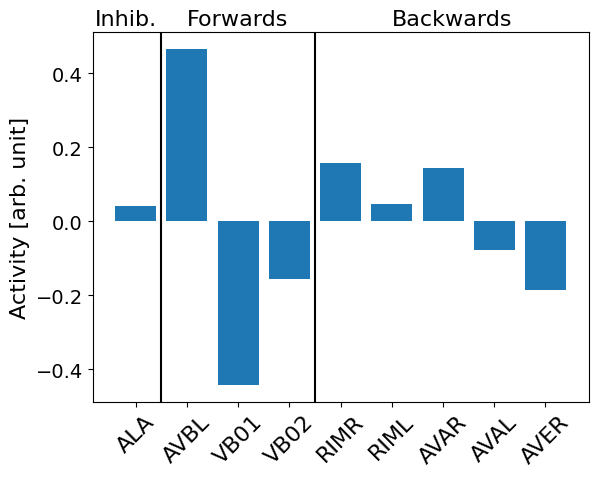

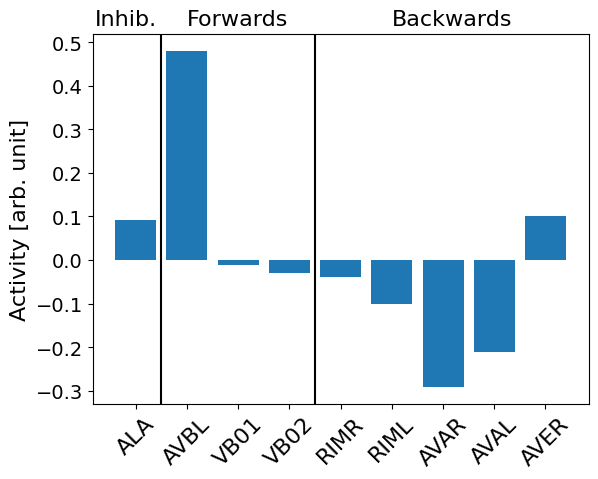

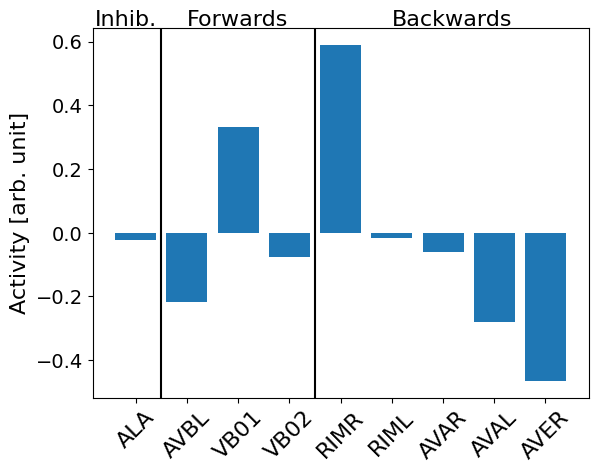

In [18]:
rearrangement=[4,9,14,13,11,12,5,6,7]
barWidth = 0.8
# Set position of bar on X axis
br1 = np.arange(len(rearrangement))

fig, ax = plt.subplots()
plt.bar(np.array(br1),eigvecs[rearrangement,0], width = barWidth)
plt.axvline(x = 0.5, color = 'k')
plt.axvline(x = 3.5, color = 'k')
plt.text(-0.8,0.465,'Inhib.',fontsize=16)
plt.text(1,0.465,'Forwards',fontsize=16)
plt.text(5,0.465,'Backwards',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(br1,nIDs_all_worms[rearrangement],rotation=45,fontsize=16)
fig.savefig('PCA_1_Mode_Bar.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

rearrangement=[4,9,14,13,11,12,5,6,7]
barWidth = 0.8
# Set position of bar on X axis
br1 = np.arange(len(rearrangement))

fig, ax = plt.subplots()
plt.bar(np.array(br1),eigvecs[rearrangement,1], width = barWidth)
plt.axvline(x = 0.5, color = 'k')
plt.axvline(x = 3.5, color = 'k')
plt.text(-0.8,0.485,'Inhib.',fontsize=16)
plt.text(1,0.485,'Forwards',fontsize=16)
plt.text(5,0.485,'Backwards',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(br1,nIDs_all_worms[rearrangement],rotation=45,fontsize=16)
fig.savefig('PCA_2_Mode_Bar.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

rearrangement=[4,9,14,13,11,12,5,6,7]
barWidth = 0.8
# Set position of bar on X axis
br1 = np.arange(len(rearrangement))

fig, ax = plt.subplots()
plt.bar(np.array(br1),eigvecs[rearrangement,2], width = barWidth)
plt.axvline(x = 0.5, color = 'k')
plt.axvline(x = 3.5, color = 'k')
plt.text(-0.8,0.53,'Inhib.',fontsize=16)
plt.text(1,0.53,'Forwards',fontsize=16)
plt.text(5,0.53,'Backwards',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(br1,nIDs_all_worms[rearrangement],rotation=45,fontsize=16)
fig.savefig('PCA_3_Mode_Bar.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

rearrangement=[4,9,14,13,11,12,5,6,7]
barWidth = 0.8
# Set position of bar on X axis
br1 = np.arange(len(rearrangement))

fig, ax = plt.subplots()
plt.bar(np.array(br1),eigvecs[rearrangement,3], width = barWidth)
plt.axvline(x = 0.5, color = 'k')
plt.axvline(x = 3.5, color = 'k')
plt.text(-0.8,0.54,'Inhib.',fontsize=16)
plt.text(1,0.54,'Forwards',fontsize=16)
plt.text(5,0.54,'Backwards',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(br1,nIDs_all_worms[rearrangement],rotation=45,fontsize=16)
fig.savefig('PCA_4_Mode_Bar.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

rearrangement=[4,9,14,13,11,12,5,6,7]
barWidth = 0.8
# Set position of bar on X axis
br1 = np.arange(len(rearrangement))

fig, ax = plt.subplots()
plt.bar(np.array(br1),eigvecs[rearrangement,4], width = barWidth)
plt.axvline(x = 0.5, color = 'k')
plt.axvline(x = 3.5, color = 'k')
plt.text(-0.8,0.65,'Inhib.',fontsize=16)
plt.text(1,0.65,'Forwards',fontsize=16)
plt.text(5,0.65,'Backwards',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(br1,nIDs_all_worms[rearrangement],rotation=45,fontsize=16)
fig.savefig('PCA_5_Mode_Bar.png', format='png', dpi=600,bbox_inches='tight')
plt.show()



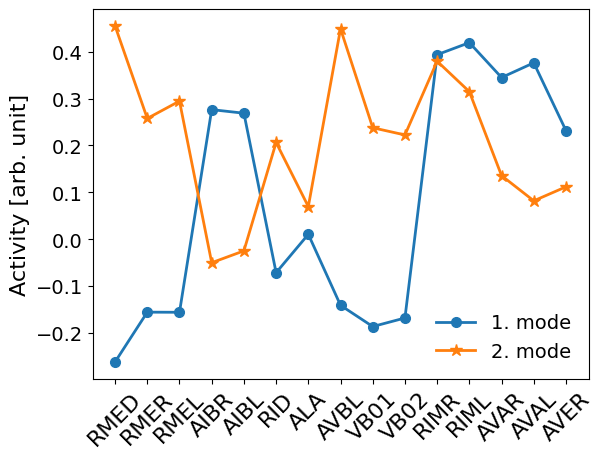

In [115]:
rearrangement=[0,1,2,8,10,3,4,9,14,13,11,12,5,6,7]

fig, ax = plt.subplots()
plt.plot(eigvecs[rearrangement,0],marker='o',markersize=7,linewidth=2,label='1. mode')
plt.plot(eigvecs[rearrangement,1],marker='*',markersize=9,linewidth=2,label='2. mode')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(frameon=False,fontsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(range(len(nIDs_all_worms)),nIDs_all_worms[rearrangement],rotation=45,fontsize=16)
fig.savefig('PCA_Modes_sorted.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

#### One can see that the mode associated to teh smallest variance doesn't contain a lot of information

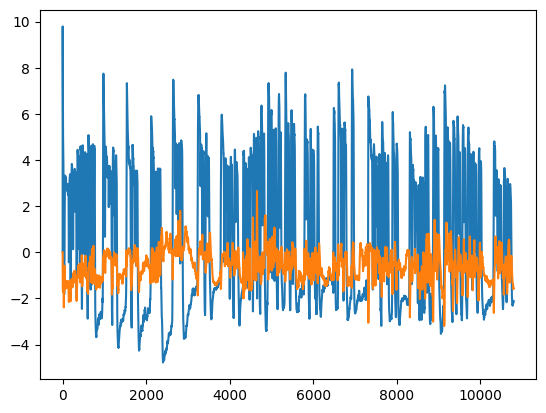

In [32]:
#One can see that the least variance mode has very little variability
plt.figure()
plt.plot(projectedData[:,0])
plt.plot(projectedData[:,-1])

#### If we go back to observation space, parts of the features are suppressed

(10800, 5)
(10800, 15)


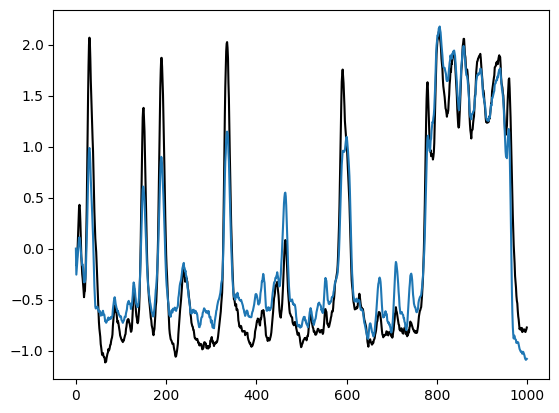

In [54]:
projectedData=np.dot(X_all,eigvecs[:,:5])
print(projectedData.shape)

Obsspace=np.dot(projectedData,eigvecs[:,:5].T)
print(Obsspace.shape)

plt.figure()
plt.plot(X_all[0:1000,0],'k')
plt.plot(Obsspace[0:1000,0])
